In [1]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

import io
import fitz
import re
from PIL import Image, ImageDraw, ImageFont, ImageColor
import operator
import os
import pandas as pd 
import numpy as np
from datetime import datetime
import math
from tqdm import tqdm

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import io
import fitz
import re
from PIL import Image, ImageDraw, ImageFont, ImageColor
import operator
import os
import pandas as pd 
import numpy as np
from datetime import datetime
import math
from tqdm import tqdm
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont


from matplotlib import pyplot as plt

In [2]:
parent = "../" 
"""INDEX 1"""
pdf_dir1 = parent + "input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 1.pdf"
doc1 = fitz.open(pdf_dir1)
pages1 = [doc1[i] for i in range(doc1.page_count)]
index1 = range(616, 639)
"""INDEX 1"""


"""INDEX 2"""
pdf_dir2 = parent + "/input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 2.pdf"
doc2 = fitz.open(pdf_dir2)
pages2 = [doc2[i] for i in range(doc2.page_count)]
index2 = list(range(703, 725))
"""INDEX 2"""

"""INDEX 3"""
pdf_dir3 = parent + "input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 3.pdf"
doc3 = fitz.open(pdf_dir3)
pages3 = [doc3[i] for i in range(doc3.page_count)]
index3 = list(range(555, 583))
"""INDEX 3"""


TARGET_DPI = 300
mat = fitz.Matrix(TARGET_DPI/ 72, TARGET_DPI/ 72)

indent_groups = []
indent_err = 15

In [3]:
pdf_dir = pdf_dir3
doc = doc3
pages = pages3
index = index3
vol = 3

In [4]:
#next step: see if results are the same if we break it into 2 parts? 
#if still same see how we can find better ways to separate the x and y sides? Maybe a different algorithm? 
myFont = ImageFont.truetype("Arial", 15)

result_ims = []
i_list, x0_list, centers = [], [], []
start = 0 #2*len(pages)//4
end = len(pages) #len(pages)
for page_num in tqdm(range(start, end)):
    block_lst = pages[page_num].get_text("dict")['blocks']

    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)

    line_x = []
    for b in block_lst:
        if b['type'] == 0:
            for l in b['lines']:
                x0 = l['bbox'][0]*(TARGET_DPI/ 72)
                #if x0 < 500:
                line_x0 = x0
                line_x.append(line_x0)
    line_x = np.array(line_x).reshape(-1, 1)

    #print(line_x)
    #bandwidth = max(estimate_bandwidth(line_x, quantile=0.25), 10) #basically setting 10 to our error now
    #with this bandwidth quantile have to do one per column (so will also need )

    #ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)
    
    #bandwidth = estimate_bandwidth(line_x, quantile=0.25, n_samples=500)
    # print(bandwidth)
    # if bandwidth > 30:
    #     print("bandwith error")
    #     bandwidth = 30

    ms = MeanShift(bandwidth=15, bin_seeding=True)
    #ms = MeanShift(bin_seeding=True)

    ms.fit(line_x)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    centers += list(zip([page_num]*len(cluster_centers), cluster_centers.flatten()))
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    #print(page_num, "number of estimated clusters : %d" % n_clusters_)


    blank_im = Image.new('RGB', image.size, (255, 255, 255))
    blank_draw = ImageDraw.Draw(blank_im)
    dy_block_lst = []
    x0, y0, x1, y1 = 0, 0, 0, 0
    myFont = ImageFont.truetype("Arial", 15)
    g_i = 0
    #block_lst = dict(block_lst)
    i = 0
    for b in block_lst:
        if b['type'] == 0:
            for l in b['lines']:
                #for s in l['spans']:
                #    for w in s['text']:
                prev_x0, prev_y0, prev_x1, prev_y1 = x0, y0, x1, y1
                x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in l['bbox']]
                #if x0 < 500:
                
                draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"))
                draw.text((x0 - 5, y0 - 5), str(labels[i]), font=myFont, fill =(255, 0, 0))
                
                i += 1 
                i_list.append(page_num)
                x0_list.append(x0)
    i = 0
    for c in cluster_centers.flatten():
        draw.rectangle((c, 0, c+1, 2000), fill=None, outline=ImageColor.getrgb("#222222"))
        draw.text((c-10, 30), str(i), font=myFont, fill =(255, 0, 0))
        i += 1 
    result_ims.append(image)


  0%|          | 0/588 [00:00<?, ?it/s]/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_mean_shift.py:246: UserWarning: Binning data failed with provided bin_size=15.000000, using data points as seeds.
  warnings.warn(
  0%|          | 1/588 [00:00<03:07,  3.13it/s]/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_mean_shift.py:246: UserWarning: Binning data failed with provided bin_size=15.000000, using data points as seeds.
  warnings.warn(
  2%|▏         | 12/588 [00:02<02:06,  4.56it/s]


KeyboardInterrupt: 

In [8]:
result_ims[0].save('../output/index/clustering/x_cluster_'+str(vol)+'.pdf',save_all=True, append_images=result_ims[1:])

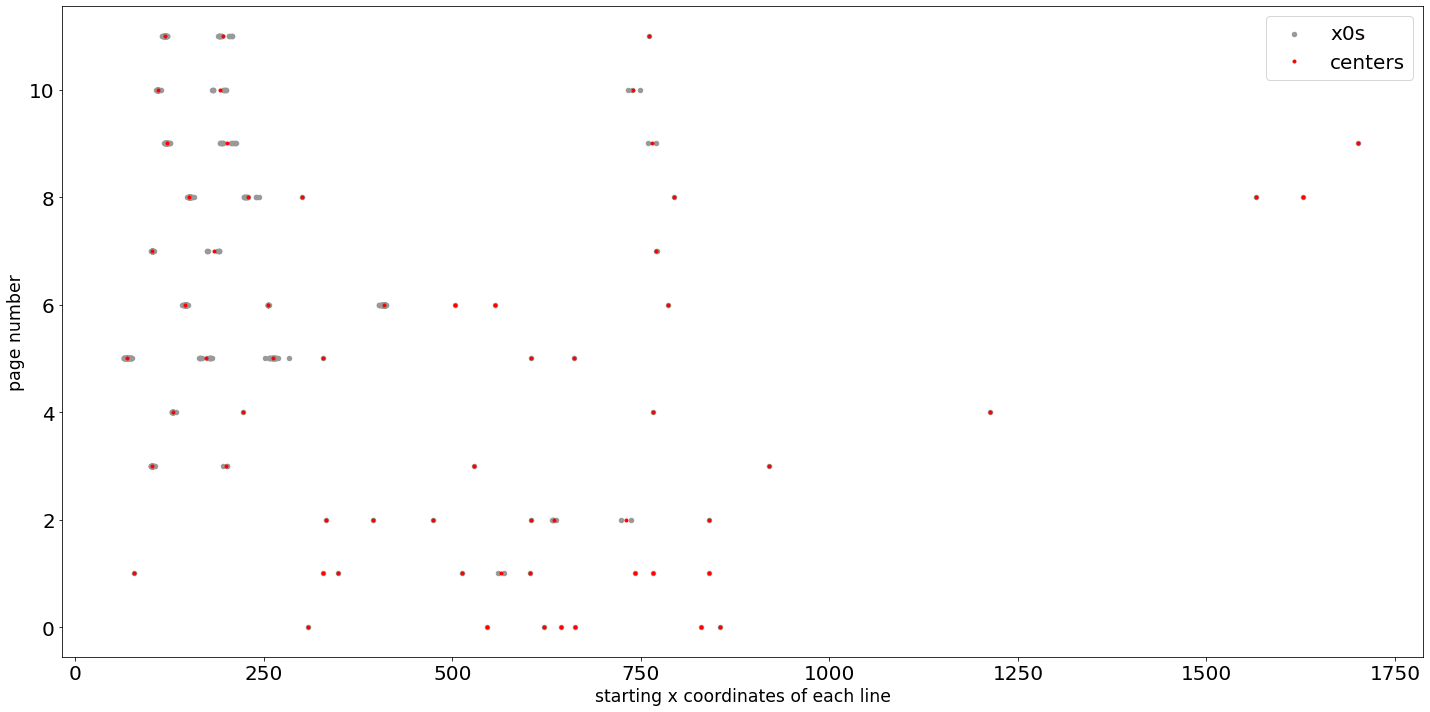

In [5]:
from cProfile import label


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
#xs = np.random.rand(100)
#ys = np.random.rand(100)
xs, ys = i_list, x0_list
#xs = [1, 1, 5,1, 2, 3]
#ys = [2, 5, 10, 3, 1, 5]

plt.figure(figsize=(20, 10))
x_c, y_c = np.array(centers).T

plt.scatter(ys, xs, s = 20, cmap='gray', c= '0.6', label = "x0s")
plt.plot(y_c, x_c, 'r.', label = "centers")
plt.tick_params(labelsize=20)

plt.xlabel("starting x coordinates of each line", size='xx-large')
plt.ylabel("page number", size='xx-large')

plt.legend(prop={'size': 20}, loc='upper right')
plt.show()

In [6]:
page_num = index[1]
block_lst = pages[page_num].get_text("dict")['blocks']

pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
draw = ImageDraw.Draw(image)

line_x = []
for b in block_lst:
    if b['type'] == 0:
        for l in b['lines']:
            x0 = l['bbox'][0]*(TARGET_DPI/ 72)
            #if x0 < 500:
            line_x0 = x0
            line_x.append(line_x0)
line_x = np.array(line_x).reshape(-1, 1)

#print(line_x)
#bandwidth = max(estimate_bandwidth(line_x, quantile=0.25), 10) #basically setting 10 to our error now
#with this bandwidth quantile have to do one per column (so will also need )

#ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)

#bandwidth = estimate_bandwidth(line_x, quantile=0.25, n_samples=500)
# print(bandwidth)
# if bandwidth > 30:
#     print("bandwith error")
#     bandwidth = 30

ms = MeanShift(bandwidth=15, bin_seeding=True)
#ms = MeanShift(bin_seeding=True)

ms.fit(line_x)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
centers += list(zip([page_num]*len(cluster_centers), cluster_centers.flatten()))
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

#print(page_num, "number of estimated clusters : %d" % n_clusters_)


blank_im = Image.new('RGB', image.size, (255, 255, 255))
blank_draw = ImageDraw.Draw(blank_im)
dy_block_lst = []
x0, y0, x1, y1 = 0, 0, 0, 0
myFont = ImageFont.truetype("Arial", 15)
g_i = 0
#block_lst = dict(block_lst)
i = 0
for b in block_lst:
    if b['type'] == 0:
        for l in b['lines']:
            #for s in l['spans']:
            #    for w in s['text']:
            prev_x0, prev_y0, prev_x1, prev_y1 = x0, y0, x1, y1
            x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in l['bbox']]
            #if x0 < 500:
            
            draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"))
            draw.text((x0 - 5, y0 - 5), str(labels[i]), font=myFont, fill =(255, 0, 0))
            
            i += 1 
            i_list.append(page_num)
            x0_list.append(x0)
i = 0

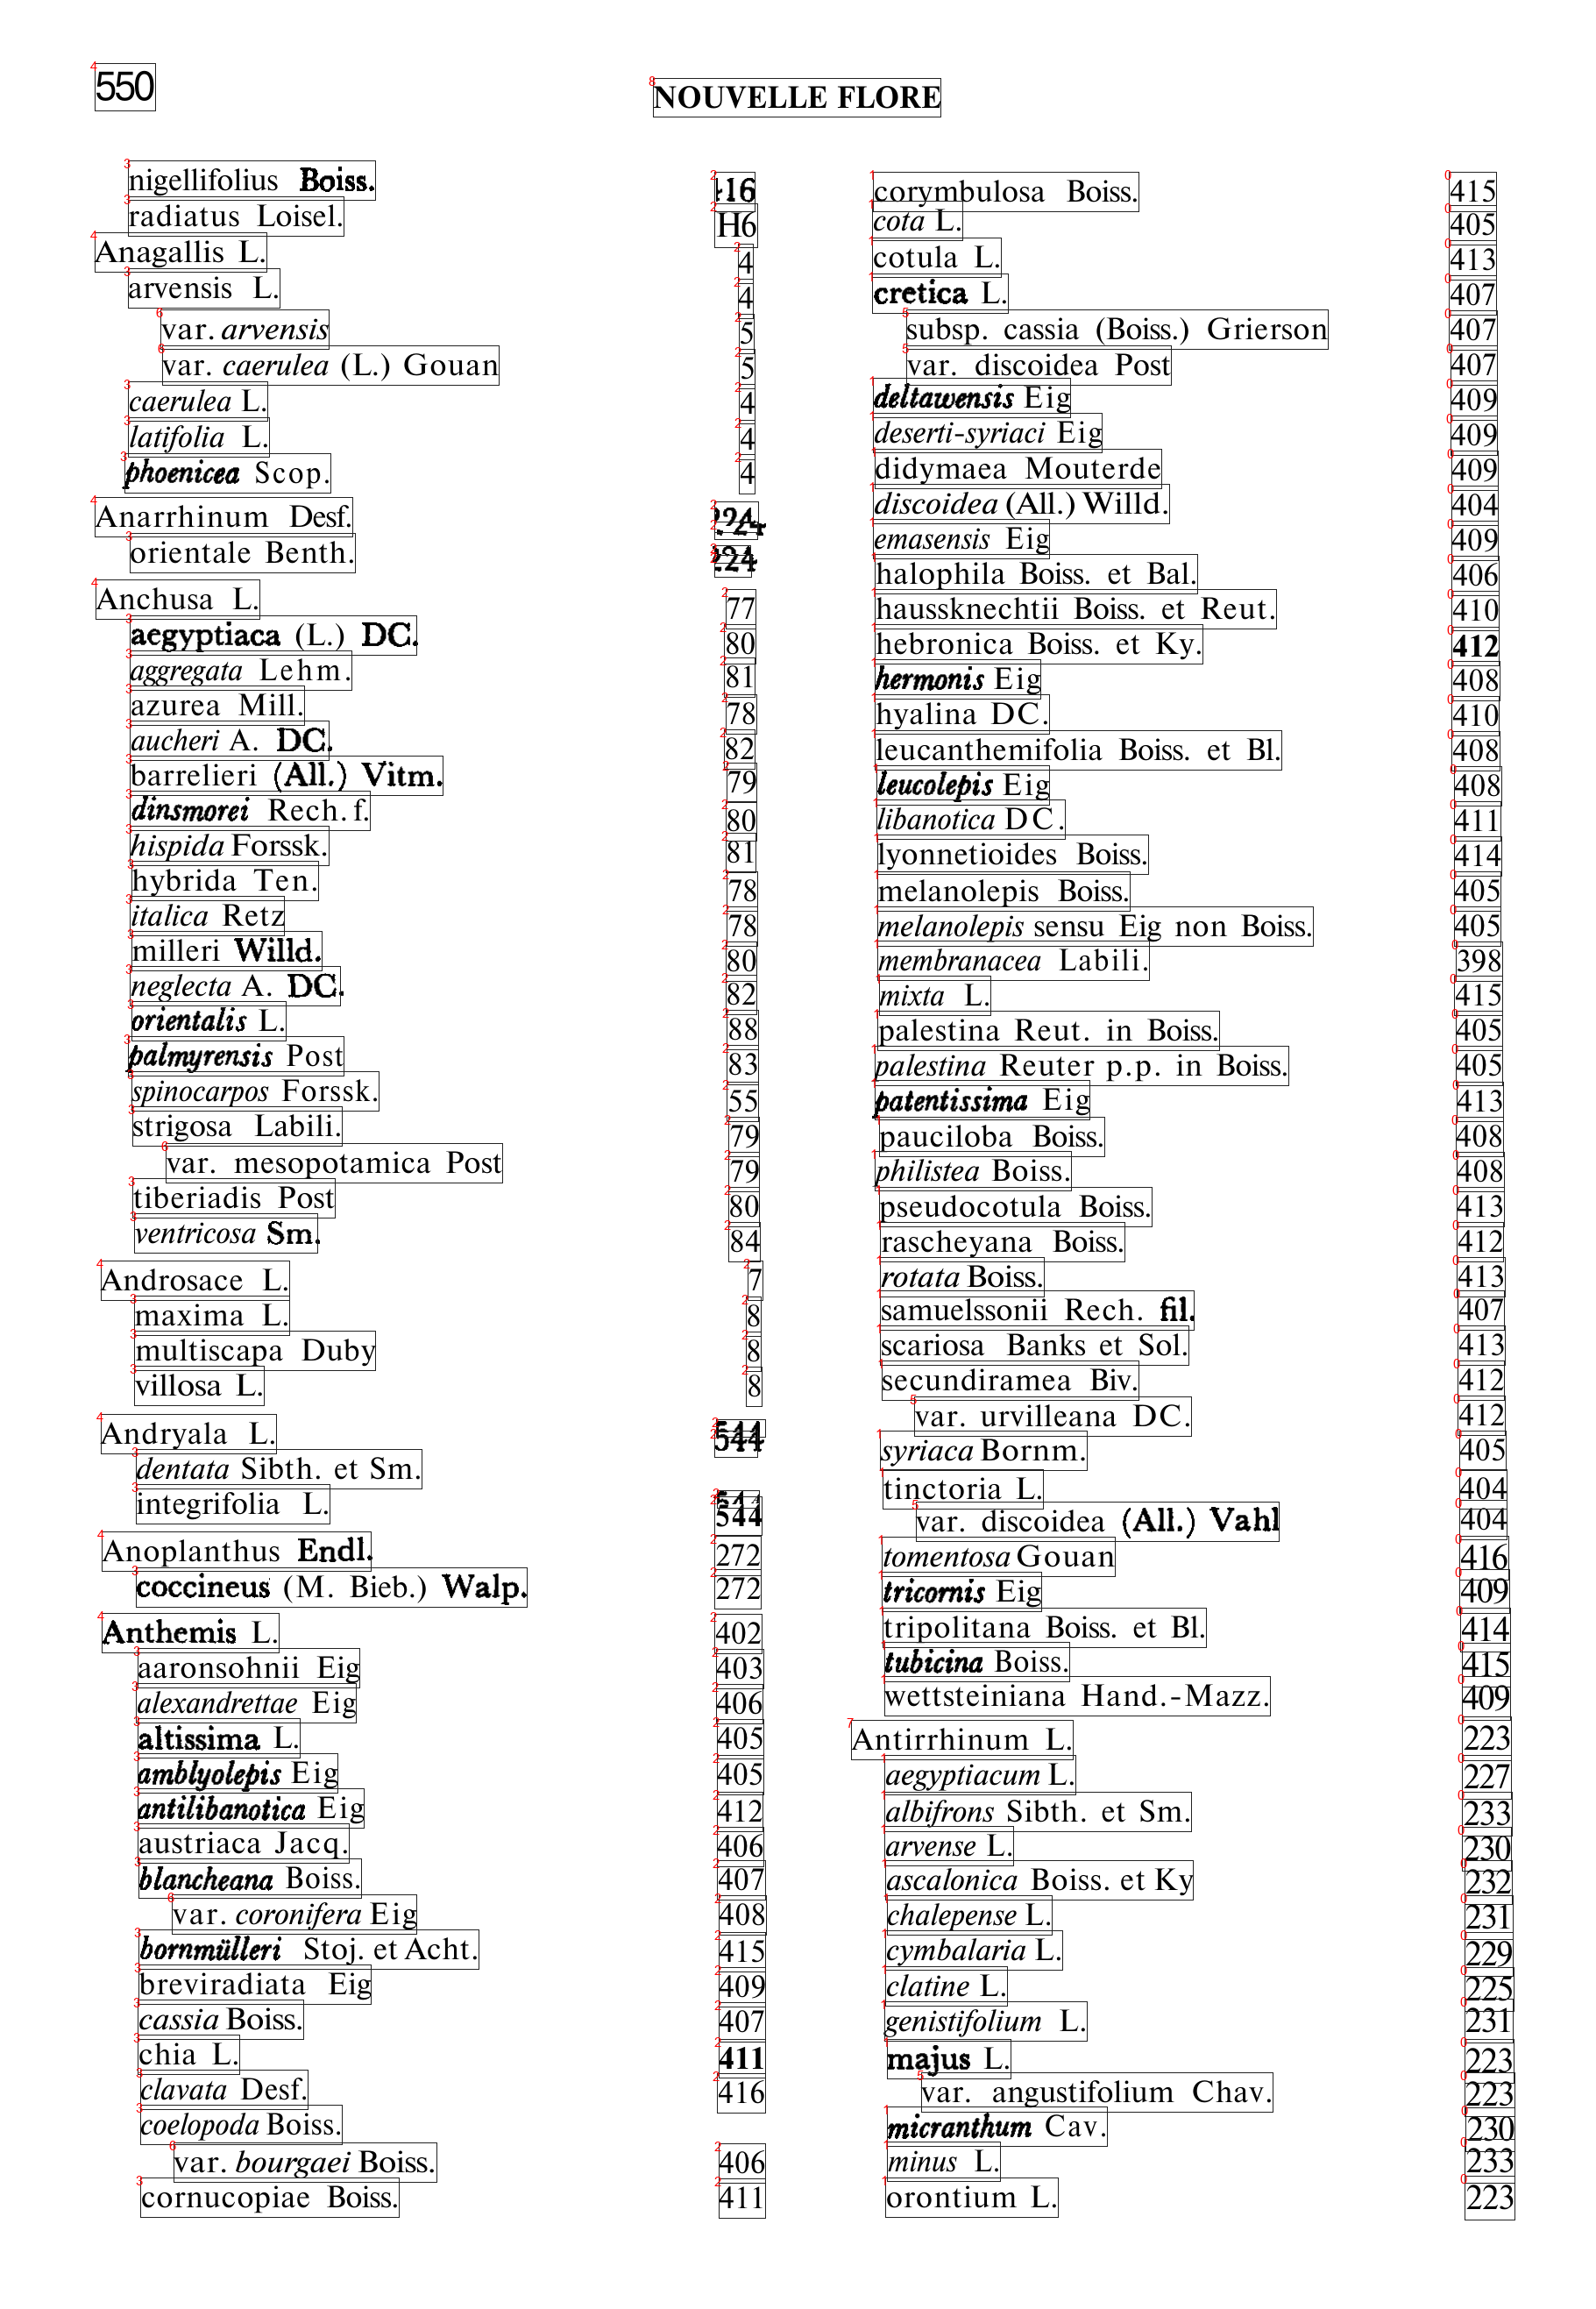

In [7]:
image

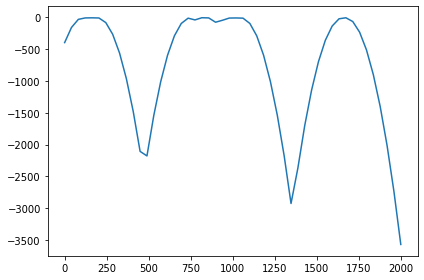

In [16]:
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot

a = line_x
kde = KernelDensity(kernel='gaussian', bandwidth=math.sqrt(15)).fit(a)
s = linspace(0,2000)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

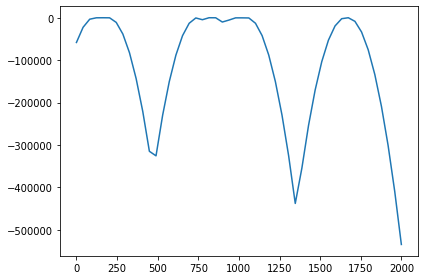

In [40]:
a = line_x
kde = KernelDensity(kernel='gaussian', bandwidth=math.sqrt(0.1)).fit(a)
s = linspace(0,2000)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [35]:
from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print(np.append(s[mi], s[ma]))

[ 489.79591837  775.51020408  897.95918367 1346.93877551  163.26530612
  734.69387755  816.32653061 1020.40816327 1673.46938776]


In [37]:

for c in np.append(s[mi], s[ma]):
    draw.rectangle((c, 0, c, 2000), fill=None, outline=ImageColor.getrgb("#222222"))
    draw.text((c-10, 30), str("hi"), font=myFont, fill =(255, 0, 0))

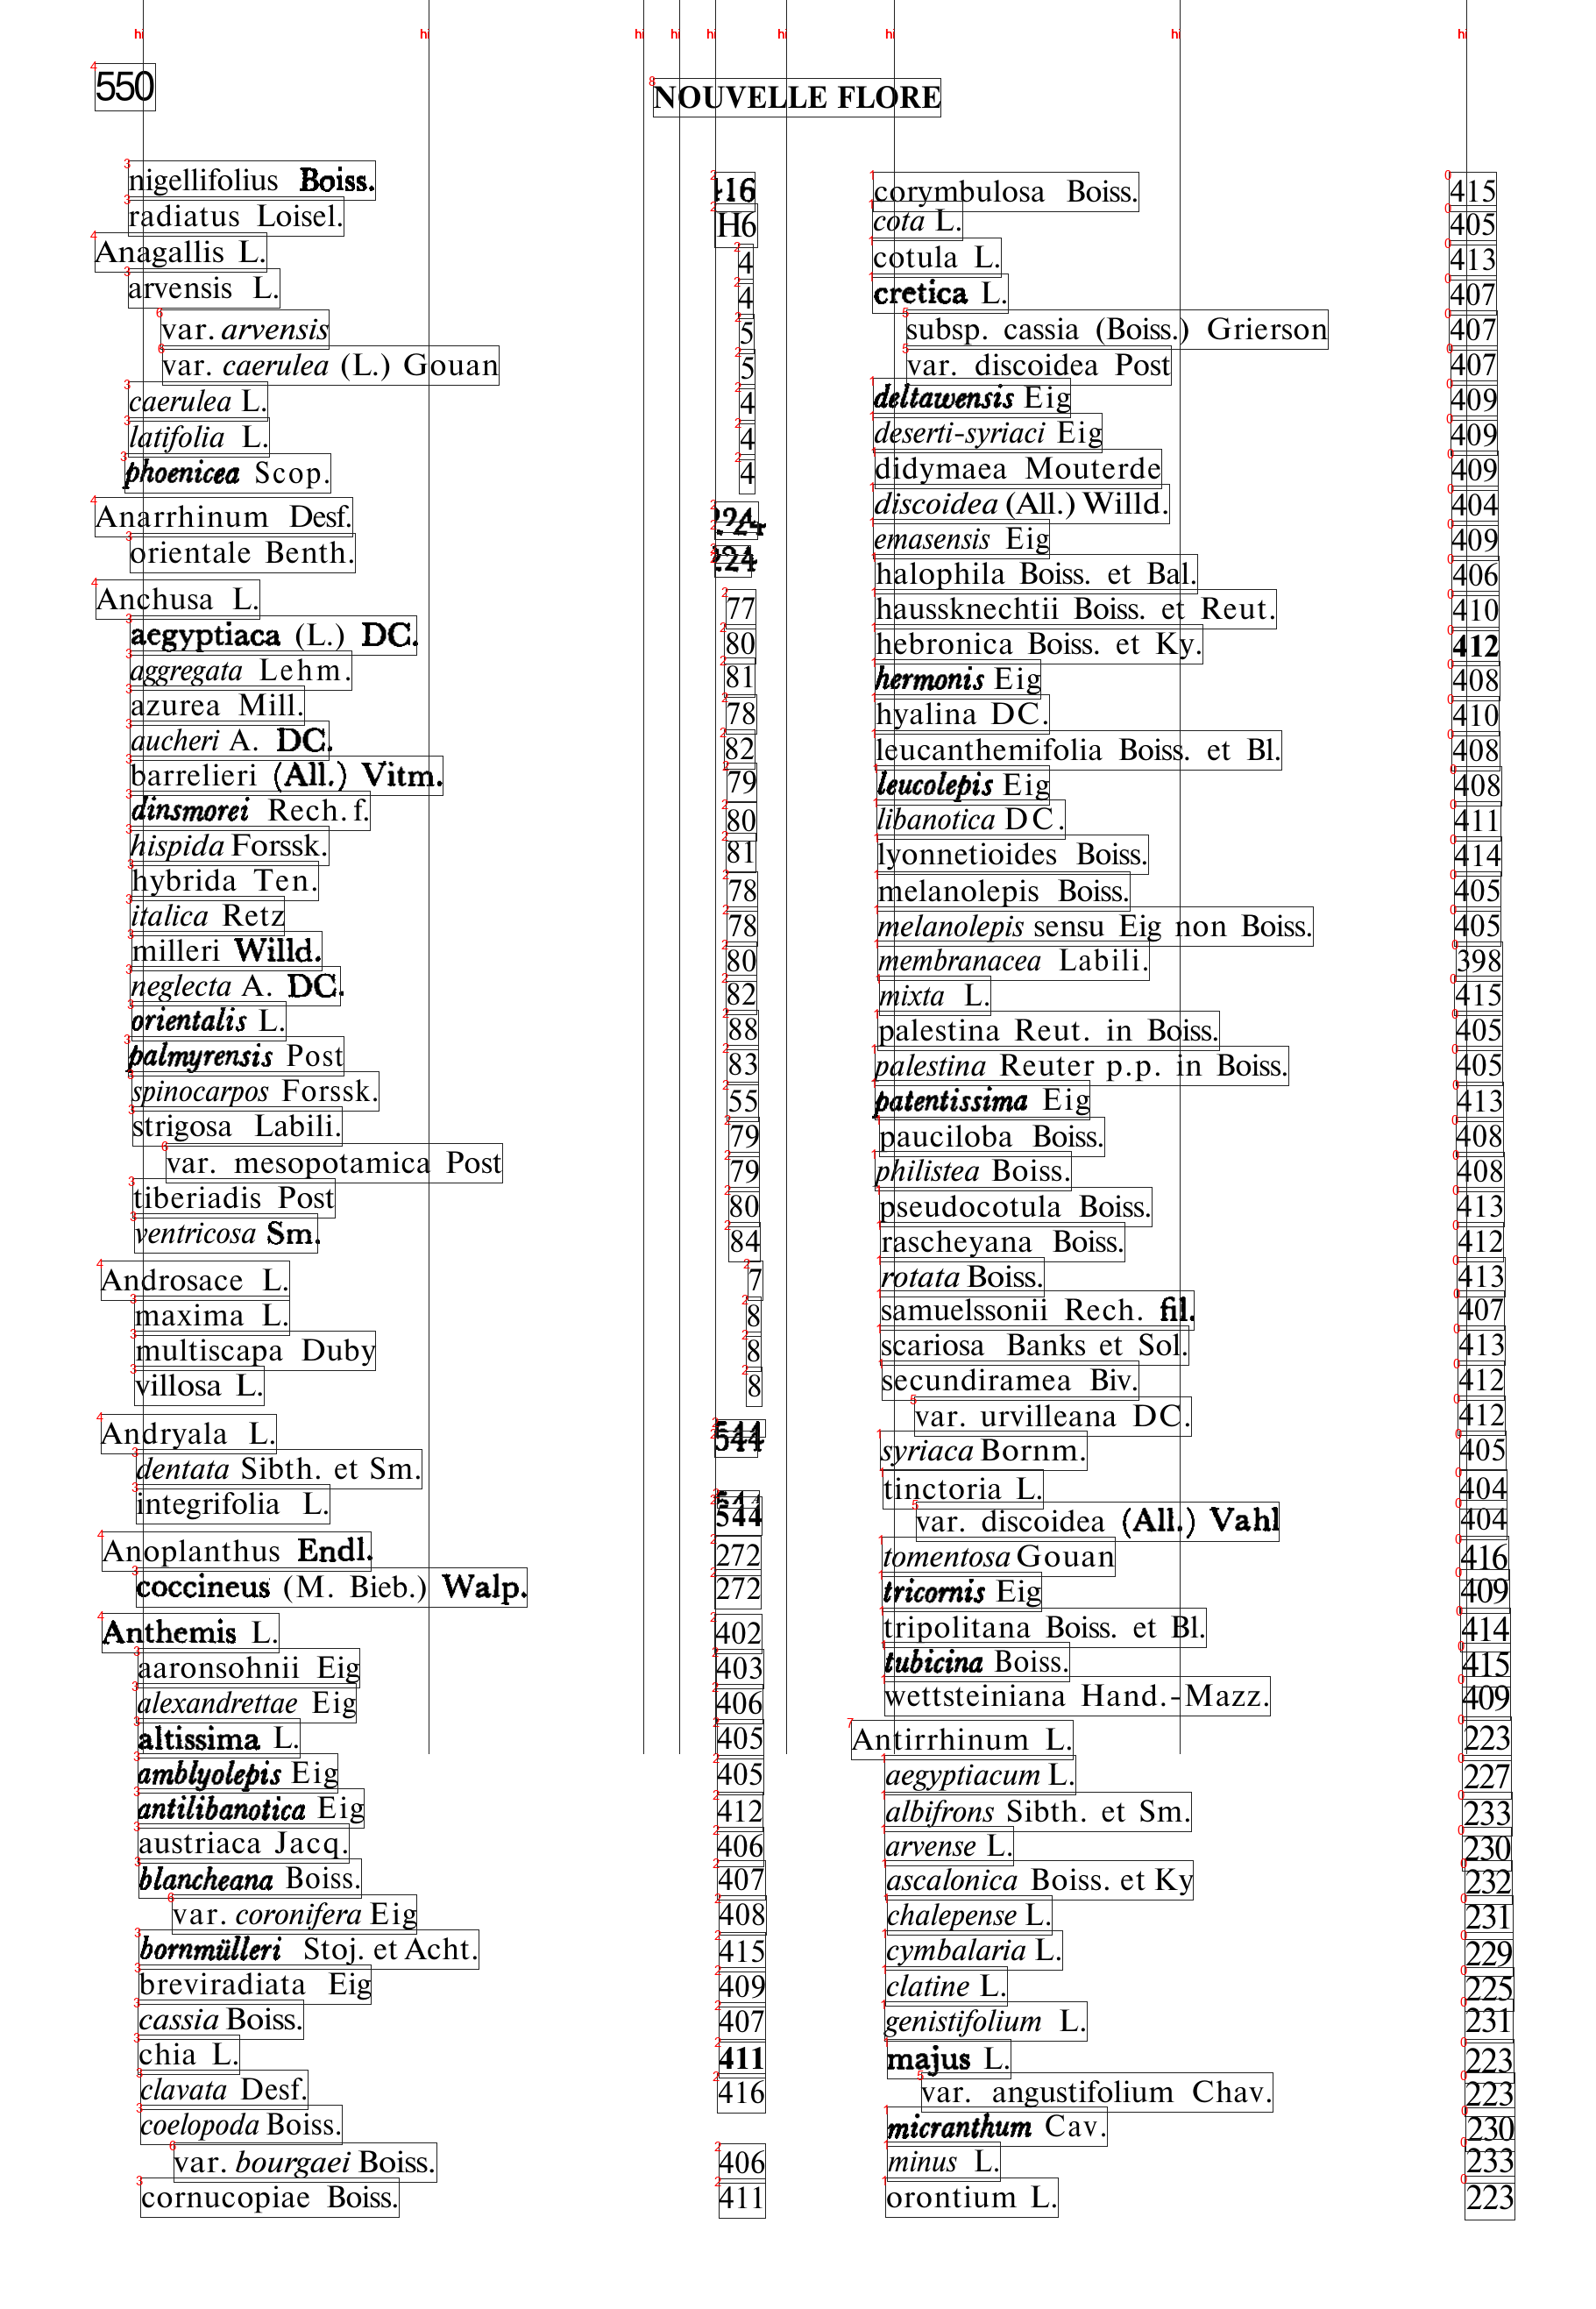

In [38]:
image

[ 9 12 22 32] [ 4 11 18 25 41]


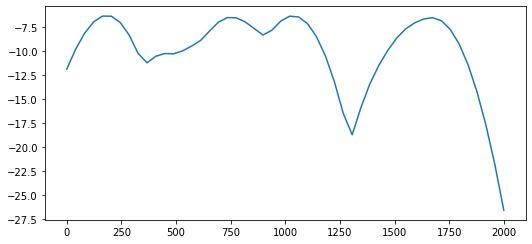

In [128]:
a = line_x
kde = KernelDensity(kernel='gaussian', bandwidth=50).fit(a)
s = linspace(0,2000)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

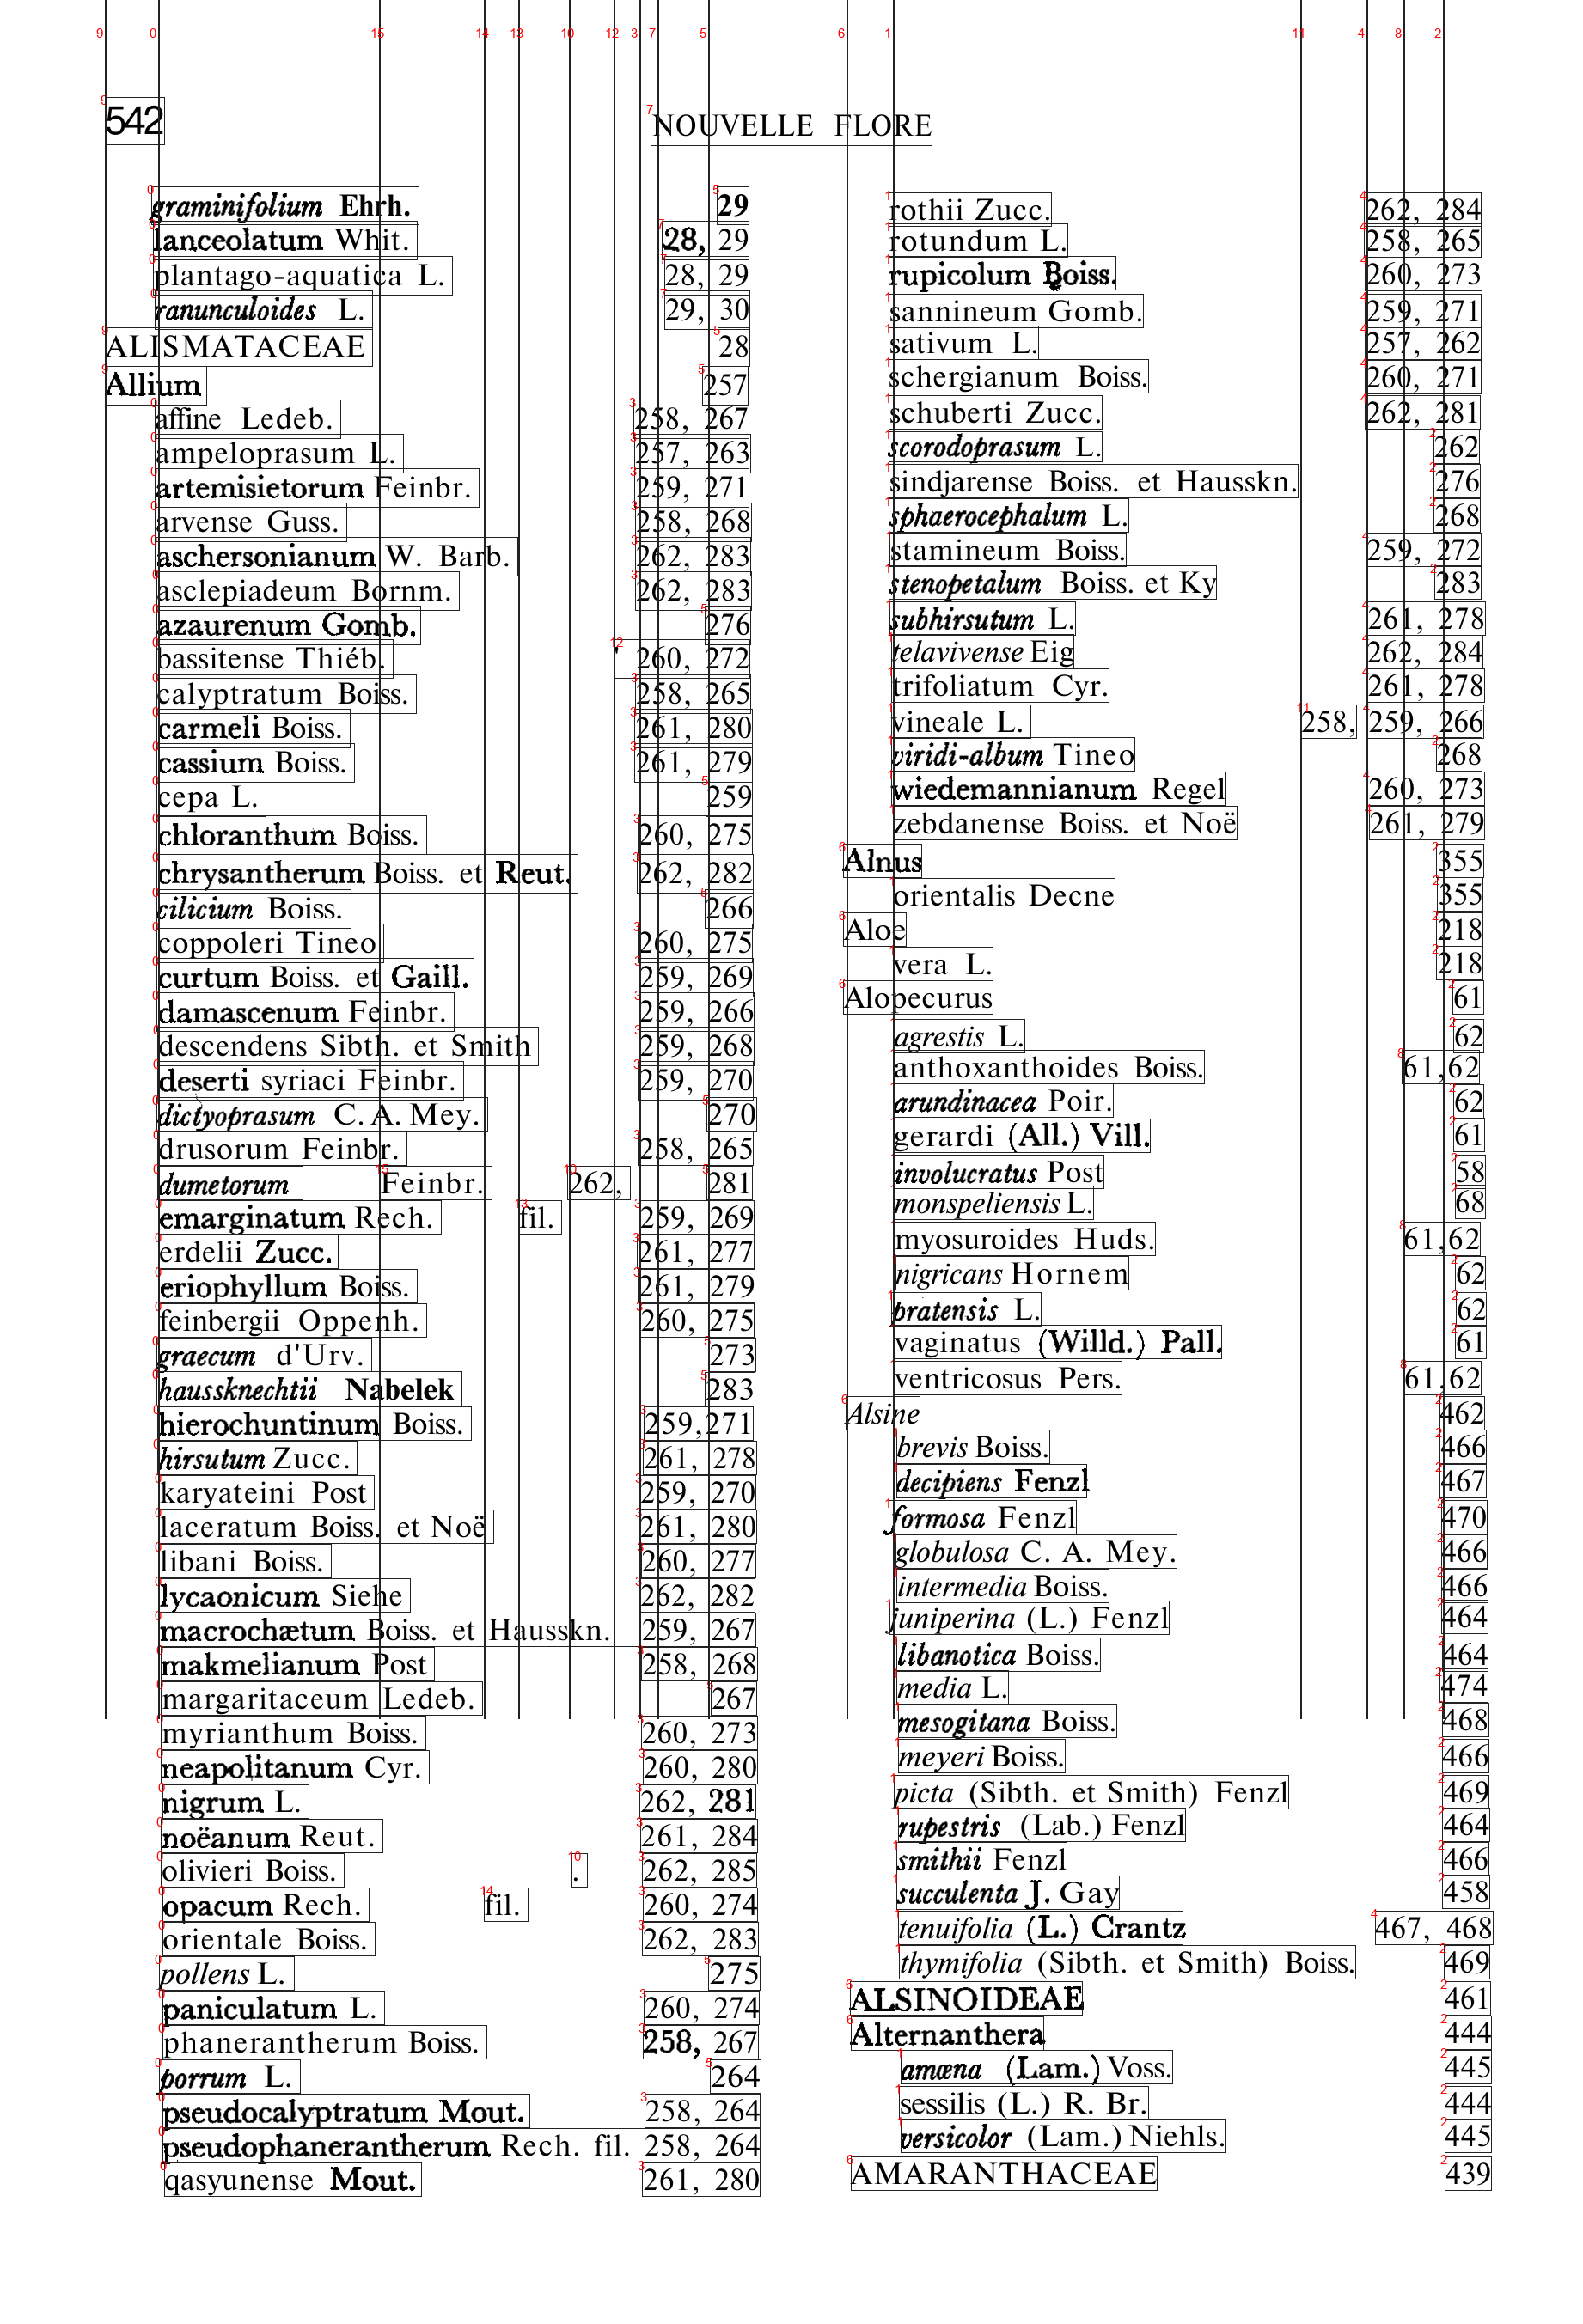

In [118]:
image

In [205]:
tp = pages[page_num].get_textpage()

In [207]:
html = tp.extractHTML()

In [209]:
print(html)

<div id="page0" style="width:4294967296.0pt;height:4294967296.0pt">
<p style="top:18.8pt;left:25.9pt;line-height:10.8pt"><span style="font-family:Arial,serif;font-size:10.8pt">550</span></p>
<p style="top:22.8pt;left:178.8pt;line-height:8.4pt"><b><span style="font-family:Times New Roman,serif;font-size:8.4pt">NOUVELLE FLORE</span></b></p>
<p style="top:45.4pt;left:35.0pt;line-height:8.4pt"><span style="font-family:Times New Roman,serif;font-size:8.4pt">nigellifolius</span><span style="font-family:Times New Roman,serif;font-size:8.6pt"> Boiss.</span></p>
<p style="top:55.2pt;left:35.0pt;line-height:8.4pt"><span style="font-family:Times New Roman,serif;font-size:8.4pt">radiatus Loisel.</span></p>
<p style="top:64.9pt;left:25.9pt;line-height:8.7pt"><span style="font-family:Times New Roman,serif;font-size:8.7pt">Anagallis L.</span></p>
<p style="top:74.9pt;left:35.0pt;line-height:8.4pt"><span style="font-family:Times New Roman,serif;font-size:8.4pt">arvensis L.</span></p>
<p style="top:86.

In [41]:
g1 = np.random.normal(100, 5, 50)
g2 = np.random.normal(120, 5, 50)
g3 = np.random.normal(500, 5, 50)
g3 = np.random.normal(1800, 5, 50)